In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import random

import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from astropy.table import Table
from tqdm.notebook import tqdm
import h5py

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style='ticks')
pd.set_option('mode.chained_assignment', None)

In [4]:
%matplotlib inline

# Toy problem

## Problem definition

In [5]:
# Create the problem
np.random.seed(1254)
z_true = scipy.stats.beta.rvs(a=1.5, b=8, size=10000) * 6

exps = np.exp(z_true)
exps = (exps - min(exps)) / (max(exps) - min(exps))

logs = np.log(z_true)
logs = (logs - min(logs)) / (max(logs) - min(logs))

err = (exps + 0.6) * (logs * 0.9) * (z_true / 1.4)  # z_true / 3

err[err == 0] = 0.0001

z_obs = []
for i in range(len(err)):
    new_val = -1
    while new_val <= 0:
        new_val = z_true[i] + np.random.normal(loc=0.0, scale=err[i])
    z_obs.append(new_val) 

data = pd.DataFrame()
data['z_true'] = z_true
data['err'] = err
data['z_obs'] = z_obs

In [6]:
# Create binning for abstract p(z)s
z_max = 6
step = 0.01
bins_p = np.arange(0, z_max + step, step)
z_p = [bins_p[i] + (bins_p[i + 1] - bins_p[i]) / 2 for i in range(len(bins_p) - 1)]

# Create abstract p(z) matrix
pz_mat = np.array([scipy.stats.norm.pdf(z_p, data.loc[i, 'z_obs'], data.loc[i, 'err']) for i in range(data.shape[0])])

# Create binning for final p(z)
step = 0.1
bins = np.arange(0, z_max + step, step)
z = [bins[i] + (bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)]

pz_dict = {}
err_dict = {}

In [7]:
def make_toy_plot(data=None, z_arr=None, pz_dict=None, err_dict=None, method=None, with_base=True,
                  with_observed=True):
    # Plot the toy problem
    # if with_base:
    #     data['z_true'].hist(histtype='step', bins=100, label='true', density=True)
    pdf_beta = scipy.stats.beta.pdf(np.array(z_arr) / 6, a=1.5, b=8) / 6
    plt.plot(z_arr, pdf_beta, label='true')
        
    if with_observed:
        data['z_obs'].hist(histtype='step', bins=100, label='observed', density=True)

    if method:
        plt.plot(z_arr, pz_dict[method], label=method, alpha=0.6)
        plt.fill_between(z_arr, pz_dict[method] - err_dict[method],
                         pz_dict[method] + err_dict[method], alpha=0.2, color='C2')

    plt.axhline(y=0, color='gray', linestyle='-')
    plt.xlabel('z')
    plt.ylabel('p(z)')
    plt.xlim((None, 6))
    plt.legend()

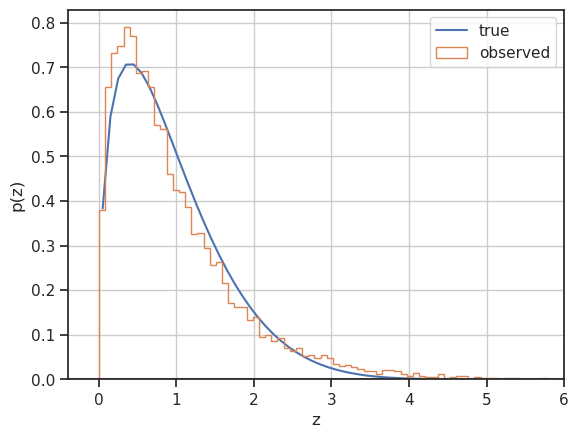

In [8]:
# Plot the toy problem
make_toy_plot(data, z)

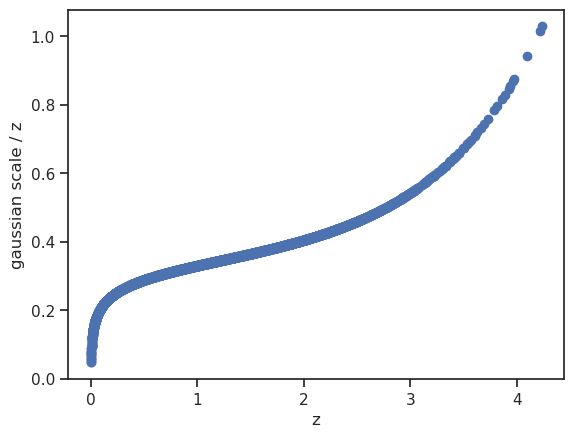

In [9]:
# Plot error vs redshift
plt.figure()
plt.scatter(data['z_true'], data['err'] / data['z_true'])
plt.xlabel('z')
plt.ylabel('gaussian scale / z')
plt.show()

## Methods

In [10]:
def get_gaussian_pz(data, bins):
    step = bins[1] - bins[0]
    z_arr = [bins[i] + (bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)]

    # Most simple approach, just counts maxima and takes mean of errors
    counts = data.groupby(pd.cut(data['z_obs'], bins=bins))['z_obs'].count().to_numpy()
    err = data['err'].groupby(pd.cut(data['z_obs'], bins=bins)).mean().to_numpy()

    for i in range(len(err)):
        vals = counts[np.where(np.logical_and(z_arr > z_arr[i] - err[i], z_arr < z_arr[i] + err[i]))]
        err[i] = np.std(vals)

    s = np.sum(counts) * step
    p = counts / s
    err = err / s

    return p, err


def get_resampled_pz(z_p, pz_mat, bins, n_samples=1000):
    histograms = []
    for _ in tqdm(range(n_samples)):

        # for each row in pz_mat get one value
        new_sample = []
        for i in range(pz_mat.shape[0]):
            new_sample.append(random.choices(z_p, k=1, weights=pz_mat[i])[0])

        histograms.append(np.histogram(new_sample, bins=bins)[0])

    mean = np.mean(histograms, axis=0)
    std = np.std(histograms, axis=0)

    step = bins[1] - bins[0]
    s = mean.sum() * step

    mean = mean / s
    std = std / s

    return mean, std


def get_one_sigma_pz(data, bins):
    central = np.histogram(data['z_obs'], bins=bins)[0]
    left = np.histogram(data['z_obs'] - data['err'], bins=bins)[0]
    right = np.histogram(data['z_obs'] + data['err'], bins=bins)[0]

    return central, left, right

    vals = list(zip(central, left, right))
    vals = np.array([sorted(vals_i) for vals_i in vals])

    min = vals[:, 0]
    mean = vals[:, 1]
    max = vals[:, 2]

    step = bins[1] - bins[0]
    s = mean.sum() * step
    min = min / s
    mean = mean / s
    max = max / s

    return mean, (max - min) / 2


def get_bootstrap_pz(pz_mat, n_samples=1000):
    n_obj = pz_mat.shape[0]

    # Get bootstrap samples
    histograms = []
    for _ in tqdm(range(n_samples)):
        idx = np.random.randint(0, n_obj, n_obj)
        histograms.append(pz_mat[idx].sum(axis=0) / n_obj)

    mean = np.mean(histograms, axis=0)
    std = np.std(histograms, axis=0)

    return mean, std

## Results

### Gaussian method

In [11]:
method = 'gaussian'

In [12]:
pz_dict[method], err_dict[method] = get_gaussian_pz(data, bins)

/home/sjnakoneczny/tools/anaconda3/envs/py39-lofar-dr2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sjnakoneczny/tools/anaconda3/envs/py39-lofar-dr2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/sjnakoneczny/tools/anaconda3/envs/py39-lofar-dr2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


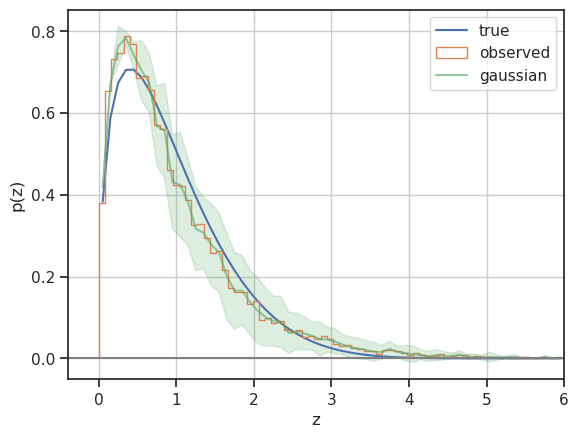

In [13]:
# This result depends on the binning, weird
make_toy_plot(data, z, pz_dict, err_dict, method=method)

### Sampling

In [14]:
method = 'resampled'

In [16]:
pz_dict[method], err_dict[method] = get_resampled_pz(z_p, pz_mat, bins, n_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

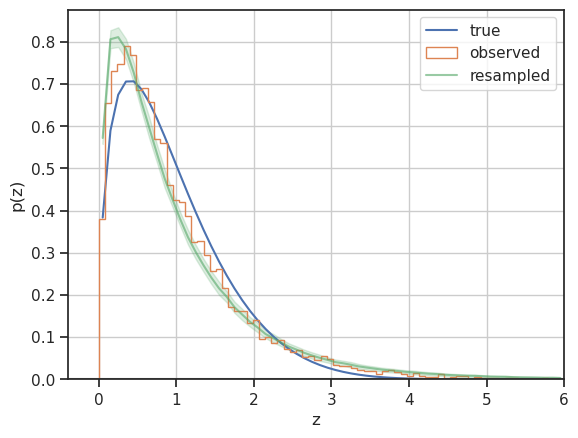

In [17]:
make_toy_plot(data, z, pz_dict, err_dict, method=method)

### Bootstrapping

In [18]:
method = 'bootstrap'

In [19]:
pz_dict[method], err_dict[method] = get_bootstrap_pz(pz_mat, n_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

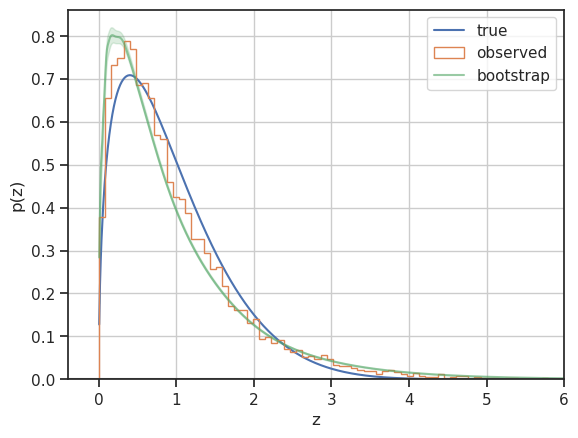

In [20]:
make_toy_plot(data, z_p, pz_dict, err_dict, method=method)

### Only error sampling

In [21]:
method = 'only error sampling'

In [23]:
pz_dict[method] = pz_dict['gaussian']
err_dict[method] = err_dict['resampled']

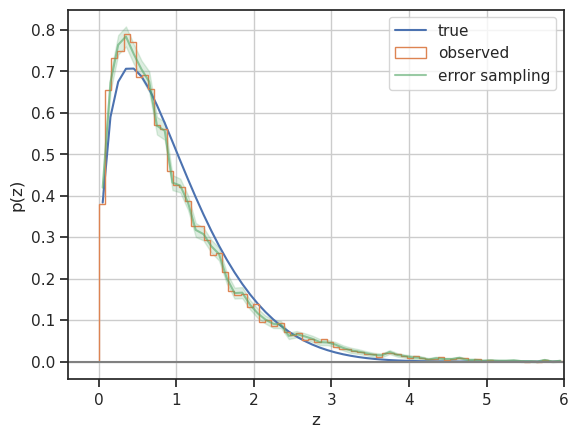

In [24]:
make_toy_plot(data, z, pz_dict, err_dict, method=method)

### Entropy fix

In [148]:
entropies = []
for i in range(len(data)):
    entropies.append(scipy.stats.entropy(pz_mat[i]))

data['entropy'] = entropies

In [149]:
weights = data.groupby(pd.cut(data['z_obs'], bins=bins))['entropy'].mean().to_numpy()

In [150]:
weights = np.nan_to_num(weights)

In [151]:
pz_dict['entropy'] = pz_dict['error sampling'] * weights
err_dict['entropy'] = err_dict['error sampling'] * weights

s = pz_dict['entropy'].sum() * step
pz_dict['entropy'] = pz_dict['entropy'] / s
err_dict['entropy'] = err_dict['entropy'] / s

err_dict['entropy'] = err_dict['error sampling']

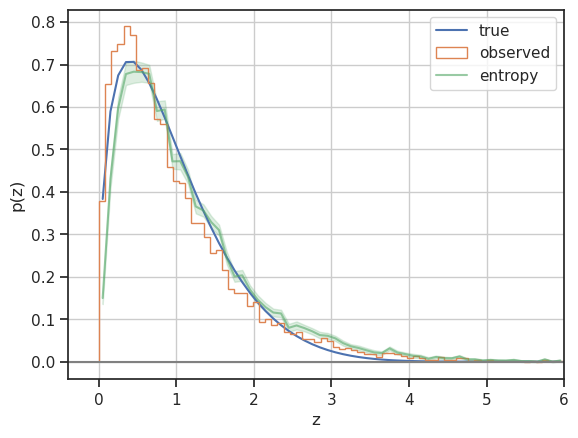

In [152]:
make_toy_plot(data, z, pz_dict, err_dict, method='entropy')

### One sigma

In [159]:
method = 'one sigma'

In [160]:
pz_dict[method], err_dict[method] = get_one_sigma_pz(data, bins)

In [162]:
err_dict[method]

array([0.27856997, 0.36667346, 0.35648808, 0.23528213, 0.17111428,
       0.11815034, 0.09421471, 0.03106539, 0.05805663, 0.04176003,
       0.04481564, 0.07078835, 0.08250153, 0.08402933, 0.07537177,
       0.09217763, 0.07537177, 0.09370544, 0.07129762, 0.06569566,
       0.07384396, 0.06060297, 0.05754736, 0.05245468, 0.05551029,
       0.03513954, 0.03972296, 0.04125076, 0.03208393, 0.0407415 ,
       0.03208393, 0.02546343, 0.02750051, 0.02393563, 0.02851905,
       0.02495417, 0.01222245, 0.01935221, 0.01527806, 0.01986148,
       0.01578733, 0.01425952, 0.01222245, 0.00509269, 0.01069464,
       0.00865757, 0.00865757, 0.00865757, 0.00865757, 0.00407415,
       0.00662049, 0.00203707, 0.00203707, 0.00254634, 0.00203707,
       0.00763903, 0.00458342, 0.00305561, 0.00305561, 0.00203707])

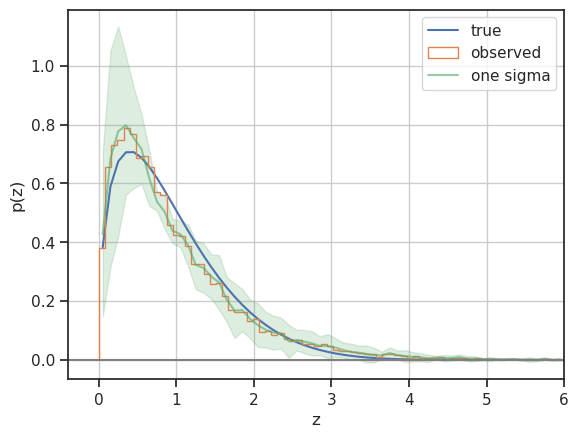

In [161]:
make_toy_plot(data, z, pz_dict, err_dict, method=method)

In [163]:
central, left, right = get_one_sigma_pz(data, bins)

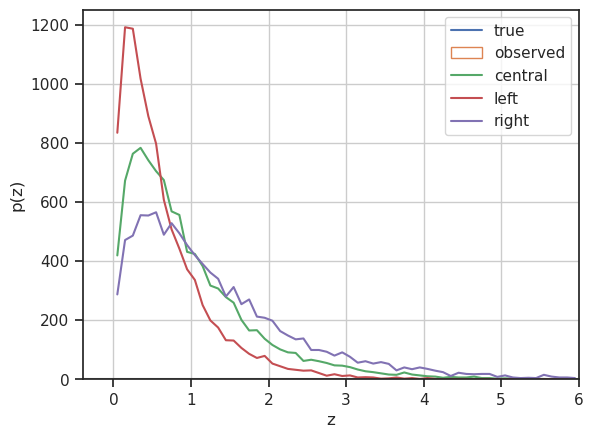

In [164]:
make_toy_plot(data, z)

plt.plot(z, central, label='central')
plt.plot(z, left, label='left')
plt.plot(z, right, label='right')

plt.legend()

In [ ]:
pz_dict[method] = pz_dict['bootstrap']
err_dict[method] = err_dict['resampled']

# Deep fields

## Read data

In [5]:
def get_deepfields_data(flux_min_cut=1.5, snr_cut=7.5):
    file_path = os.path.join(DATA_PATH, 'LoTSS/DR2/deep_fields/{}_final_cross_match_catalogue-v1.0.fits')
    fields = ['bootes', 'en1', 'lockman']
    
    data_dict, pz_dict = {}, {}
    for field in fields:
        print('Reading {}'.format(field))
        
        # Read data
        data = Table.read(file_path.format(field), format='fits')
        data = data['Total_flux', 'Peak_flux', 'Isl_rms', 'Z_BEST', 'Z_BEST_SOURCE', 'z1_median', 'z1_min', 'z1_max']
        data = data.to_pandas()
        print('All objects: {}'.format(data.shape))

        # Flux cut
        data = data.loc[data['Total_flux'] > flux_min_cut * 1.e-3]
        print('Total flux of S > {} mJy: {}'.format(flux_min_cut, data.shape))

        # Signal to noise ratio cut
        data = data.loc[data['Peak_flux'] / data['Isl_rms'] > snr_cut]
        print('Signal to noise > {}: {}'.format(snr_cut, data.shape))

        # Redshift available
        data = data.dropna(subset=['Z_BEST', 'z1_median'])
        print('Redshift available: {}'.format(data.shape))
        print('--------------------')
        
        # p(z) files
        date = '20221020' if field == 'lockman' else '20221011'
        f = h5py.File(os.path.join(DATA_PATH, 'LoTSS/DR2/deep_fields/{}_final_cross_match_catalogue-v1.0_{}.hdf'.format(field, date)), 'r')
        z = np.array(f[list(f.keys())[3]])
        pz_dict[field] = np.array(f[list(f.keys())[0]])[data.index.values]
        
        # Reset index after selecting p(z)
        data_dict[field] = data.reset_index(drop=True)

    return data_dict, z, pz_dict

In [6]:
flux_min_cut = 1.5
snr_cut = 7.5

fields = ['bootes', 'en1', 'lockman']

In [7]:
data_dict, z_fields, pz_fields = get_deepfields_data(flux_min_cut, snr_cut)

Reading bootes
All objects: (19179, 8)
Total flux of S > 1.5 mJy: (1848, 8)
Signal to noise > 7.5: (1790, 8)
Redshift available: (1651, 8)
--------------------
Reading en1
All objects: (31610, 8)
Total flux of S > 1.5 mJy: (1287, 8)
Signal to noise > 7.5: (1260, 8)
Redshift available: (1193, 8)
--------------------
Reading lockman
All objects: (31162, 8)
Total flux of S > 1.5 mJy: (2169, 8)
Signal to noise > 7.5: (2117, 8)
Redshift available: (1962, 8)
--------------------


In [8]:
data_dict['all'] = pd.concat([data_dict[field] for field in fields]).reset_index(drop=True)
pz_fields['all'] = np.concatenate([pz_fields[field] for field in fields])

## Methods

In [88]:
def get_pz(data_dict, z_p, pz_dict, bins, n_samples=10000):
    bin_sizes = np.array([bins[i + 1] - bins[i] for i in range(len(bins) - 1)])
    fields = ['bootes', 'en1', 'lockman']

    # Weights
    lens = dict((field, len(data_dict[field])) for field in fields)
    sum = np.sum(list(lens.values()))
    weights = dict((key, len / sum) for key, len in lens.items())
    print('Weights: {}'.format(weights))
    
    # Single histograms
    histograms = {}
    for field in fields:
        step = bins[1] - bins[0]
        n_hist = int(n_samples * weights[field])
        
        # Part from spectroscopic
        idx_spec = data_dict[field]['Z_BEST_SOURCE'] == 1
        vals_spec = data_dict[field].loc[idx_spec, 'Z_BEST'].to_numpy()

        # Part from pz
        idx_photo = np.where(data_dict[field]['Z_BEST_SOURCE'] == 0)[0]
        histograms[field] = []
        for _ in tqdm(range(n_hist)):
            # for each row in pz_mat get one value
            vals_photo = []
            for i in idx_photo:
                vals_photo.append(random.choices(z_p, k=1, weights=pz_dict[field][i])[0])
            histograms[field].append(np.histogram(np.concatenate([vals_spec, vals_photo]), bins)[0])

    # Merge histograms
    pz_mean, pz_std = {}, {}
    all_hists = np.concatenate(list(histograms.values()))    
    pz_mean['all'] = np.mean(all_hists, axis=0)
    pz_std['all'] = np.std(all_hists, axis=0)
    for field in fields:
        pz_mean[field] = np.mean(histograms[field], axis=0)
        pz_std[field] = np.std(histograms[field], axis=0)

    # Normalize to probability
    for key in pz_mean:
        s = pz_mean[key].sum()
        pz_mean[key] = pz_mean[key] / (bin_sizes * s)
        pz_std[key] = pz_std[key] / (bin_sizes * s)

    return pz_mean, pz_std

## Results

### Mean only

In [141]:
# Create binning for estimated p(z)
z_max = 7.0

# first_left = 0.01
# bins = np.geomspace(first_left, z_max, 50)
# bins = np.concatenate([[0], bins])

bins = np.arange(0, z_max, 0.05)

z = np.array([bins[i] + (bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)])
bin_sizes = np.array([bins[i + 1] - bins[i] for i in range(len(bins) - 1)])

# Create containers for estimates
pz_dict = {}
err_dict = {}

In [142]:
# Sum of the best photometric redshift values
pz_dict['z1 median'] = np.histogram(data_dict['all']['z1_median'], bins=bins)[0]

s = pz_dict['z1 median'].sum()
pz_dict['z1 median'] = pz_dict['z1 median'] / (bin_sizes * s)

In [143]:
# Sum of the best redshift value, spectroscopic and photometric
pz_dict['z best'] = np.histogram(data_dict['all']['Z_BEST'], bins=bins)[0]

s = pz_dict['z best'].sum()
pz_dict['z best'] = pz_dict['z best'] / (bin_sizes * s)

In [144]:
# Sum of the photometric PDFs
pz_dict['sum p(z)'] = np.sum(pz_fields['all'], axis=0)

s = pz_dict['sum p(z)'].sum() * (z_fields[1] - z_fields[0])
pz_dict['sum p(z)'] = pz_dict['sum p(z)'] / s

In [156]:
# Spectroscopic plus sampling of photometric
pz_dict['sampling'], err_dict['sampling'] = get_pz(data_dict, z_fields, pz_fields, bins, n_samples=200)

Weights: {'bootes': 0.3435289221806076, 'en1': 0.2482313774448606, 'lockman': 0.40823970037453183}


  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

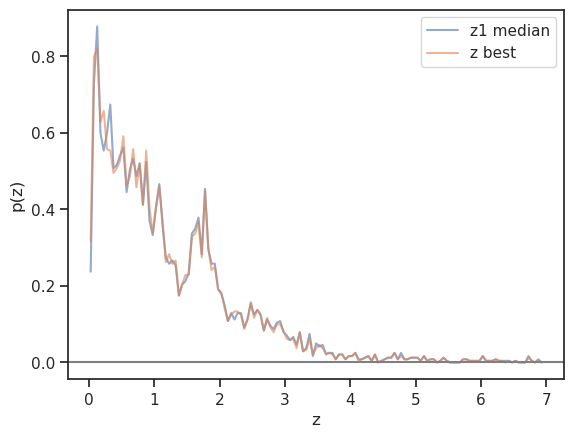

In [146]:
# Compare z best with/without spectroscopic
plt.plot(z, pz_dict['z1 median'], label='z1 median', alpha=0.6)
plt.plot(z, pz_dict['z best'], label='z best', alpha=0.6)

plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

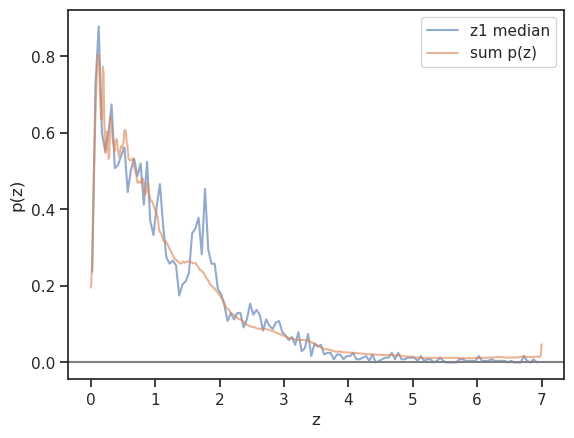

In [147]:
# Compare z best vs sum p(z) for photometric only
plt.plot(z, pz_dict['z1 median'], label='z1 median', alpha=0.6)
plt.plot(z_fields, pz_dict['sum p(z)'], label='sum p(z)', alpha=0.6)

plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

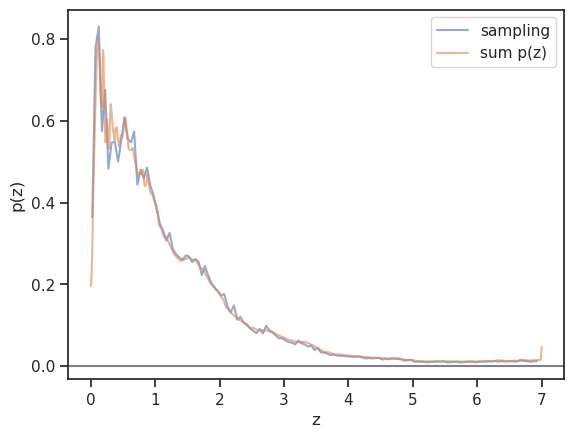

In [148]:
# Compare sampling with spectrscopic added vs sum of p(z) for photometric only
plt.plot(z, pz_dict['sampling']['all'], label='sampling', alpha=0.6)
plt.plot(z_fields, pz_dict['sum p(z)'], label='sum p(z)', alpha=0.6)

plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

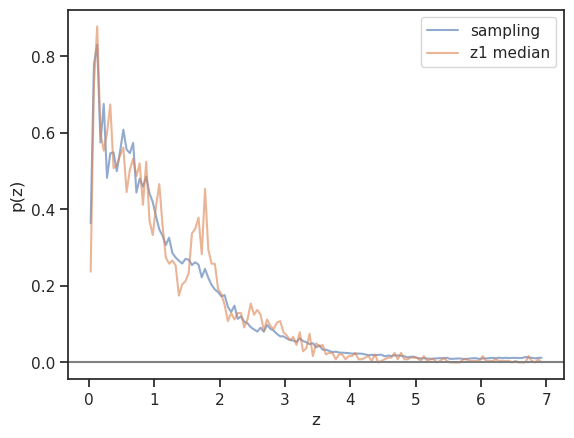

In [149]:
# Compare the most different options: sampling with spectroscopic vs sum of z best photometric
plt.plot(z, pz_dict['sampling']['all'], label='sampling', alpha=0.6)
plt.plot(z, pz_dict['z1 median'], label='z1 median', alpha=0.6)

plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

### With errors

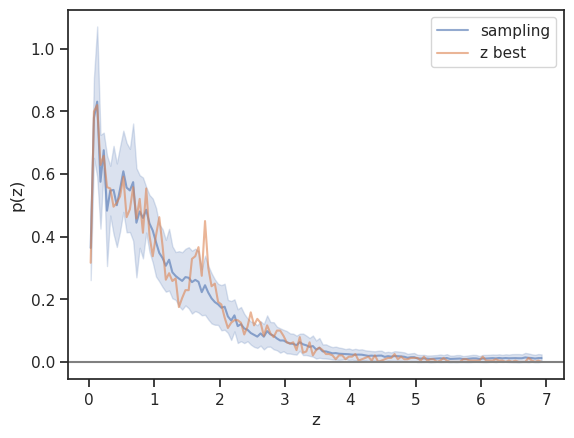

In [155]:
# Count Z_BEST vs sampling, error always from sampling
plt.plot(z, pz_dict['sampling']['all'], label='sampling', alpha=0.6)
plt.fill_between(z, pz_dict['sampling']['all'] - err_dict['sampling']['all'],
                    pz_dict['sampling']['all'] + err_dict['sampling']['all'], alpha=0.2, color='C0')

plt.plot(z, pz_dict['z best'], label='z best', alpha=0.6)

plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

### Comparison of deepfields

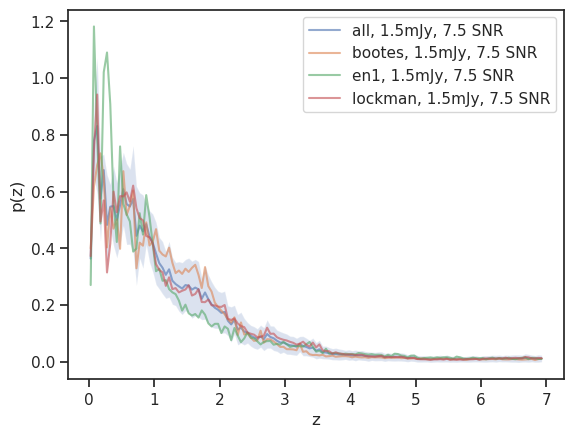

In [153]:
label = 'all, {}mJy, {} SNR'.format(flux_min_cut, snr_cut)

plt.plot(z, pz_dict['sampling']['all'], label=label, alpha=0.6)
plt.fill_between(z, pz_dict['sampling']['all'] - err_dict['sampling']['all'],
                    pz_dict['sampling']['all'] + err_dict['sampling']['all'], alpha=0.2)

for field in ['bootes', 'en1', 'lockman']:
    label = '{}, {}mJy, {} SNR'.format(field, flux_min_cut, snr_cut)
    plt.plot(z, pz_dict['sampling'][field], label=label, alpha=0.6)

plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()

## Save distributions

In [160]:
fields = ['bootes', 'en1', 'lockman']

for flux_min_cut, snr_cut in [(1.5, 7.5), (2.0, 5.0)]:
    print('Processing: flux = {}, snr = {}'.format(flux_min_cut, snr_cut))
    print('--------------------')

    # Read deep field
    data_dict, z_fields, pz_fields = get_deepfields_data(flux_min_cut, snr_cut)

    # Merge deep fields
    data_dict['all'] = pd.concat([data_dict[field] for field in fields]).reset_index(drop=True)
    pz_fields['all'] = np.concatenate([pz_fields[field] for field in fields])
    
    # Create the binning
    z_max = 7.0
    bins = np.arange(0, z_max, 0.05)
    z = np.array([bins[i] + (bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)])

    # Get p(z) and errors from the sampling method
    pz_dict, err_dict = get_pz(data_dict, z_fields, pz_fields, bins, n_samples=200)
    
    # Save
    results = pd.DataFrame()
    results['z'] = z
    for field in pz_dict:
        results['pz_{}'.format(field)] = pz_dict[field]
        results['pz_err_{}'.format(field)] = err_dict[field]

    file_path = os.path.join(DATA_PATH, 'LoTSS/DR2/deep_fields/pz_{}mJy_{}SNR.csv'.format(flux_min_cut, snr_cut))
    results.to_csv(file_path, index=False)
    print('Saved: {}'.format(file_path))
    print('--------------------')

Processing: flux = 1.5, snr = 7.5
--------------------
Reading bootes
All objects: (19179, 8)
Total flux of S > 1.5 mJy: (1848, 8)
Signal to noise > 7.5: (1790, 8)
Redshift available: (1651, 8)
--------------------
Reading en1
All objects: (31610, 8)
Total flux of S > 1.5 mJy: (1287, 8)
Signal to noise > 7.5: (1260, 8)
Redshift available: (1193, 8)
--------------------
Reading lockman
All objects: (31162, 8)
Total flux of S > 1.5 mJy: (2169, 8)
Signal to noise > 7.5: (2117, 8)
Redshift available: (1962, 8)
--------------------
Weights: {'bootes': 0.3435289221806076, 'en1': 0.2482313774448606, 'lockman': 0.40823970037453183}


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved: /home/sjnakoneczny/data/LoTSS/DR2/deep_fields/pz_1.5mJy_7.5SNR.csv
--------------------
Processing: flux = 2.0, snr = 5.0
--------------------
Reading bootes
All objects: (19179, 8)
Total flux of S > 2.0 mJy: (1379, 8)
Signal to noise > 5.0: (1369, 8)
Redshift available: (1252, 8)
--------------------
Reading en1
All objects: (31610, 8)
Total flux of S > 2.0 mJy: (968, 8)
Signal to noise > 5.0: (962, 8)
Redshift available: (901, 8)
--------------------
Reading lockman
All objects: (31162, 8)
Total flux of S > 2.0 mJy: (1617, 8)
Signal to noise > 5.0: (1610, 8)
Redshift available: (1482, 8)
--------------------
Weights: {'bootes': 0.34442916093535075, 'en1': 0.24786795048143054, 'lockman': 0.4077028885832187}


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Saved: /home/sjnakoneczny/data/LoTSS/DR2/deep_fields/pz_2.0mJy_5.0SNR.csv
--------------------


## Comparison with bootstrap

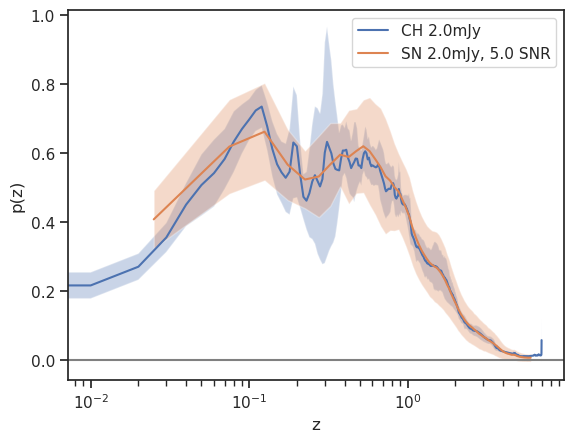

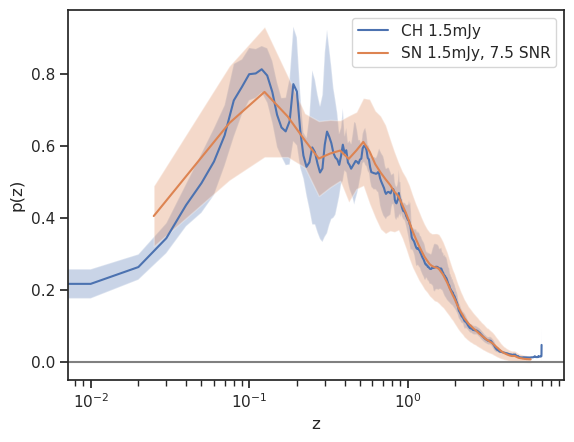

In [28]:
from utils import read_fits_to_pandas

cuts = [
    (2.0, 5.0),
    (1.5, 7.5),
]

for flux_min_cut, snr_cut in cuts:
    
    # Read CH results
    deepfields_file = 'LoTSS/DR2/pz_deepfields/AllFields_Pz_dat_Fllim1_{}_Final_Trapz_Pz.fits'.format(
            flux_min_cut)
    pz_ch = read_fits_to_pandas(os.path.join(DATA_PATH, deepfields_file))
    z_arr_ch = pz_ch['z']
    pz_arr_ch = pz_ch['Nz_weighted_fields_Photoz_only']
    err_arr_ch = pz_ch['Nz_fields_err_combafter_Photoz_only']

    # Read my results
    pz_my = pd.read_csv(os.path.join(DATA_PATH, 'LoTSS/DR2/deep_fields/pz_{}mJy_{}SNR.csv'.format(flux_min_cut, snr_cut)))
    z_arr_my = pz_my['z']
    pz_arr_my = pz_my['pz_all']
    err_arr_my = pz_my['pz_err_all']
    
    # Plot both
    plt.figure()
    
    plt.plot(z_arr_ch, pz_arr_ch, label='CH {}mJy'.format(flux_min_cut))
    plt.fill_between(z_arr_ch, pz_arr_ch - err_arr_ch, pz_arr_ch + err_arr_ch, alpha=0.3)

    plt.plot(z_arr_my, pz_arr_my, label='SN {}mJy, {} SNR'.format(flux_min_cut, snr_cut))
    plt.fill_between(z_arr_my, pz_arr_my - err_arr_my, pz_arr_my + err_arr_my, alpha=0.3)

    plt.axhline(y=0, color='gray', linestyle='-')

    plt.xlabel('z')
    plt.ylabel('p(z)')
    plt.xscale('log')
    plt.legend()
    plt.show()